In [2]:
import gensim
import itertools
import io
import matplotlib.pyplot as plt
import numpy as np
import os
import re

from gensim import corpora, models
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist

# https://rstudio-pubs-static.s3.amazonaws.com/79360_850b2a69980c4488b1db95987a24867a.html
# https://tedunderwood.com/2012/11/11/visualizing-topic-models/
# https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/

In [3]:
# Print iterations progress
def printProgressBar (iteration, total, prefix = 'Progress:', suffix = 'Complete', decimals = 1, 
                      length = 20, fill = '#'):
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print('\r%s |%s| %s%% %s' % (prefix, bar, percent, suffix), end = '\r')
    if iteration == total: 
        print()

In [63]:
def plot_histogram(x, num_bins=20):
    mu, sigma = 100, 15
    hist, bins = np.histogram(x, bins=num_bins)
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.bar(center, hist, align='center', width=width)
    plt.show()

In [5]:
# Take only the elements starting with "Visitor ID" or "Timestamp", as we
# plan to use them as keys for every group of items in the Chat.
def get_key_headers(seq, key_headers):
    for el in seq:
        if el.startswith(key_headers):
            yield el.split(": ", 1)[1][:-1].replace(':','').replace('-','')

def extract_dialogue(seq):
    """
    This function considers only the questions made by the user in the chat
    disregarding the remaining lines.
    """
    for el in seq:
        if el.startswith('(') and 'Visitor' in el:
            first_part = el[el.find(')'):]
            yield first_part[first_part.find(':')+2:-1]
            
def remove_accents(s):
    return(s.replace('á','a').replace('é','e').replace('í','i').replace('ó','o').replace('ú','u').
           replace('à','a').replace('è','e').replace('ì','i').replace('ò','o').replace('ù','u').
           replace('ä','a').replace('ë','e').replace('ï','i').replace('ö','o').replace('ü','u'))

def remove_acc(sentence):
    """
    This function remove the accents in every word in a list (sentence)
    """
    newsent = []
    for word in sentence:
        if re.search(r'[áéíóúàèìòùäëïöü]', word):
            newsent.append(remove_accents(word))
        else:
            newsent.append(word)
    return newsent

def get_filepaths(directory):
    """
    This function will generate the file names in a directory 
    tree by walking the tree either top-down or bottom-up. For each 
    directory in the tree rooted at directory top (including top itself), 
    it yields a 3-tuple (dirpath, dirnames, filenames).
    """
    file_paths = []  # List which will store all of the full filepaths.

    # Walk the tree.
    for root, directories, files in os.walk(directory):
        for filename in files:
            # Join the two strings in order to form the full filepath.
            filepath = os.path.join(root, filename)
            file_paths.append(filepath)  # Add it to the list.
    return file_paths
    
# use itertools.groupby to group lines that occur after '=====' into lists
def extract_conversations(filename, conversation_separator = '======='):
    """
    This function generates, from a set of conversation in a file (filename)
    separated by the separator specified, individual files with each of them.
    The name of the individual files are formed with the VisitorID and Timestamp.
    """
    key_headers = tuple(['Visitor ID: ', 'Timestamp: '])
    with open(filename,'r') as f:
        for key, group in itertools.groupby(f, lambda line: line.startswith(conversation_separator)):
            if not key:
                group = list(group)
                conversation_key = list(get_key_headers(group, key_headers))
                filename = "./corpus/" + '_'.join(reversed(conversation_key))
                with io.open(filename, 'w', encoding='utf-8') as output:
                    conversation = remove_acc(list(extract_dialogue(group)))
                    for item in conversation:
                        output.write("%s\n" % item)

In [6]:
def hasNumbers(inputString):
    return any(char.isdigit() for char in inputString)

def valid_tokens(tokens):
    return filter(lambda t: not hasNumbers(t) and len(t) >= 2 and len(t) <= 15, tokens)

In [7]:
def extract_tokens(filename):
    tokenizer = RegexpTokenizer(r'\w+')
    # Tokenization segments a document into its atomic elements
    f = open(filename,'r')
    raw = f.read().lower()
    tokens = tokenizer.tokenize(raw)
    return(valid_tokens(tokens))

In [8]:
def generate_stopwords():
    """
    Generate stopwords from the current list of spanish stopwords, and copy
    words with accents, but without them.
    """
    all_stopwords = stopwords.words('spanish')
    for word in all_stopwords:
        if re.search(r'[áéíóúàèìòùäëïöü]', word):
            all_stopwords.append(remove_accents(word))
    return(all_stopwords)

In [9]:
def remove_stopwords(tokens):
    # Remove Stop words from Spanish stop words list, and numbers.
    all_stopwords = generate_stopwords()
    stopped_tokens=[]
    for word in tokens:
        if word not in all_stopwords and not word.isdigit():
            stopped_tokens.append(word)
    return(stopped_tokens)

In [10]:
def extract_stems(stopped_tokens):
    # Stem words in spanish
    stemmer = SnowballStemmer("spanish")
    stemmed_tokens = [stemmer.stem(i) for i in stopped_tokens]
    return(stemmed_tokens)

In [11]:
# Generate the list of files to process, from the folders specified
parent_dir = "/Users/jrenero/OneDrive - Sanitas/DatosChats/"
datafolders = ['243861-1476443781']
#               '243861-1476691434','243861-1476698232','243861-1476698786',
#               '243861-1476691374','243861-1476691504','243861-1476698458','digital',
#               '243861-1476691412','243861-1476698142','243861-1476698730','digital_1']
datafiles = []
for folder in datafolders:
    datafiles.extend(get_filepaths(parent_dir + folder))

## Generate a separate file for each conversation

In [12]:
# Generate one file per conversation inside each data file.
#i = 0
#l = len(datafiles)
#printProgressBar(i, l)
#for file in datafiles:
#    extract_conversations(file)
#    i += 1
#    printProgressBar(i, l)

In [13]:
# Read all the files (documents) and put them into 'texts', filtering out 
# stems/words in the blacklist (badstems.txt)
texts = []
badstems_file = open('./badstems.txt','r')
bad_stems = set(badstems_file.read().splitlines())
badwords_file = open('./badwords.txt','r')
bad_words = set(badwords_file.read().splitlines())

documents = get_filepaths("./corpus/")
i = 0
l = len(documents)
printProgressBar(i, l)
for file in documents:
    tokens = extract_tokens(file)
    stopped_tokens = remove_stopwords(tokens)
    stems = extract_stems(stopped_tokens)
    ok_words = list(set(stems) - bad_stems)
    if len(ok_words) > 0:
        texts.append(ok_words)
    i += 1
    printProgressBar(i, l)

Progress: |####################| 100.0% Complete


## Run LDA model over the entire corpus.

In [14]:
# Turn our tokenized documents into a id <-> term dictionary
dictionary = corpora.Dictionary(texts)
# ignore words that appear in less than 50 documents or more than 20% documents
dictionary.filter_extremes(no_below=50, no_above=0.2)

# convert tokenized documents into a document-term matrix
corpus = [dictionary.doc2bow(text) for text in texts]

# generate LDA model
n_topics = 10
LDA = gensim.models.ldamulticore.LdaModel
ldamodel = LDA(corpus, num_topics = n_topics, id2word = dictionary, passes=1)
topics = ldamodel.print_topics(num_topics = n_topics, num_words=8)

In [15]:
def doc_stems(filename):
    tokens = extract_stems(remove_stopwords(extract_tokens(filename)))
    return(list(set(tokens) - bad_stems))

def doc_words(filename):
    tokens = remove_stopwords(extract_tokens(filename))
    return(list(set(tokens) - bad_words))

def print_topics(n):
    for i in range(0,n):
        contents = doc_words(documents[i])
        if contents:
            scores = ldamodel[dictionary.doc2bow(contents)]
            max_score = max(scores, key=lambda item:item[1]) # Get the maximum score using a lambda
            print(contents, " -> Topic:", max_score[0])
            print(topics[max_score[0]][1])
            print()

#print_topics(10)

# TF-IDF over the words on each document
We need to consider only those representative words on each document

In [16]:
import math
from textblob import TextBlob as tb

def tf(word, blob):
    return blob.words.count(word) / len(blob.words)

def n_containing(word, bloblist):
    return sum(1 for blob in bloblist if word in blob.words)

def idf(word, bloblist):
    return math.log(len(bloblist) / (1 + n_containing(word, bloblist)))

def tfidf(word, blob, bloblist):
    return tf(word, blob) * idf(word, bloblist)

### TextBlob structure

In [17]:
# A TextBlob structure is needed to perform tf-idf.
bloblist = [tb(" ".join(doc)) for doc in texts]

Create a dictionary of documents, where each word is together with its score in TF-IDF

In [18]:
feature_docs = []
for i, blob in enumerate(bloblist):
    scores = {word: tfidf(word, blob, bloblist) for word in blob.words}
    sorted_words = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    #print("Top words in document {}".format(i + 1))
    #for word, score in sorted_words[:10]:
    #    print("\tWord: {}, TF-IDF: {}".format(word, round(score, 3)))
    feature_docs.append(sorted_words)

# Show an example for the first doc.
feature_docs[1]

[('llam', 0.6512034890063662),
 ('contrat', 0.3342813343283552),
 ('medic', 0.3314356390565352),
 ('segur', 0.15864867747191946)]

### Weighting words, and picking up only relevant ones

I need the reverse dictionary where each token is associated with its id. With it, I'll be able to encode the tokens found in the conversations with their codes in the dictionary.

I build the vectors containing the list of codes on each conversation, filtering those with TF-IDF less than the value specified, or with tokens removed from the dictionary because they're no longer relevant.

In [19]:
informative_docs = map((lambda doc: list(filter((lambda x: x[1] > 0.1), doc))), feature_docs)
reverse_dict = dictionary.token2id    

def get_code(x): 
    """
    Obtain the code for each word on this document from the reverse_dictionary. 
    If the word is not found, the code assigned is -1
    """
    y = reverse_dict.get(x[0]) 
    if y != None:
        return(y) 
    else:
        return(-1)

# Build the vectors of IDs per document, removing those docs with less than 2 tokens.
# every unmatched token in the dictionary is fileterd out.
vectors = list(filter(
    (lambda vector: len(vector)>1)
    ,map((lambda doc: list(filter((lambda token_id: token_id != -1), map(get_code, doc)))), informative_docs)
))

### What is the histogram of vector lengths?
Distribution of number of relevant tokens in the conversations set?

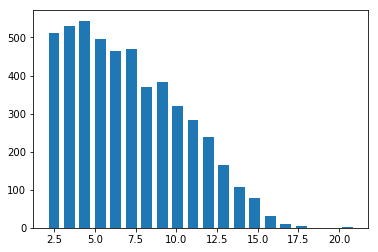

In [20]:
lengths = list(map(len, vectors))
plot_histogram(lengths)

In [81]:
max_length = max(lengths)

def list2array(v, max_length):
    np_array = np.full(max_length, -1)
    l = min(max_length, len(v))
    np_array[:l] = v[:l]
    return (np_array)

sparse_vectors = [list2array(x, max_length) for x in vectors]
type(sparse_vectors)
X = np.asmatrix(sparse_vectors)
X.shape

(5008, 21)

# Hierarchical Clustering

This part deals with the hierarchical clustering of the words in the dictionary to see how different words tend to group topgether.

https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/

In [82]:
# generate the linkage matrix
Z = linkage(X, method='ward')#, metric='jaccard')

This (very very briefly) compares (correlates) the actual pairwise distances of all your samples to those implied by the hierarchical clustering. The closer the value is to 1, the better the clustering preserves the original distances, which in our case is pretty close:

In [83]:
c, coph_dists = cophenet(Z, pdist(X))
c

0.5944233238547002

In [84]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

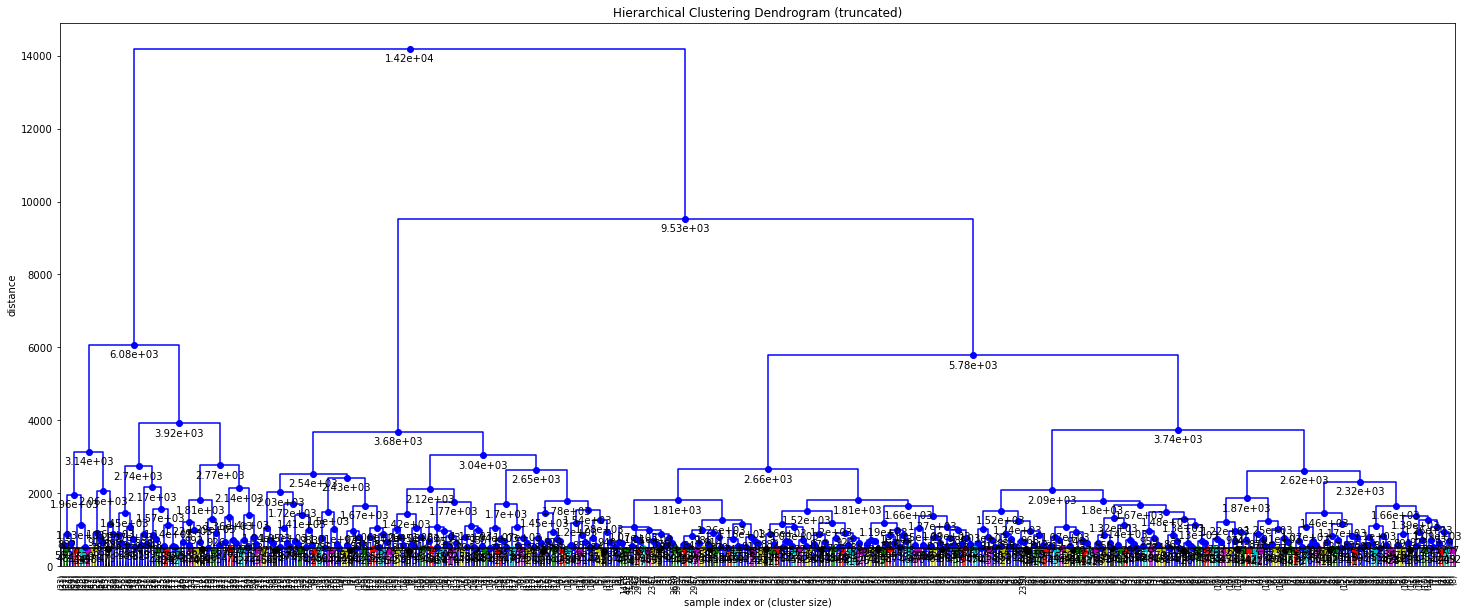

In [72]:
# calculate full dendrogram
import sys
sys.setrecursionlimit(10000)

plt.figure(figsize=(25, 10))
fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=500,
    leaf_rotation=90.,
    leaf_font_size=8.,
    show_contracted=True,
    annotate_above=10,
    max_d=500,  # plot a horizontal cut-off line
)
plt.show()

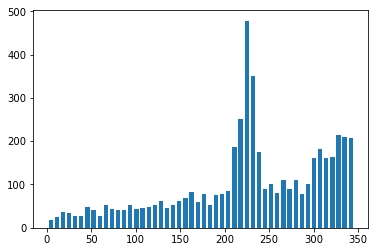

Num of clusters =  345


In [120]:
from scipy.cluster.hierarchy import fcluster
max_d = 500
clusters = fcluster(Z, max_d, criterion='distance')
plot_histogram(clusters, num_bins=50)
print("Num of clusters = ",len(set(clusters)))

In [121]:
clusters

array([324, 335, 199, ..., 305,  59, 129], dtype=int32)

In [142]:
def cluster_docs(clusters):
    """
    This method builds the list of documents present on each cluster.
    """
    cdocs = dict()
    for cluster in set(clusters):
        docs_in_cluster = [i for i,val in enumerate(clusters) if val==cluster]
        cdocs.setdefault(cluster, []).append(docs_in_cluster)
    return(cdocs)

def extract_words(vector):
    """
    From a list of word IDs, this method extract the words from the dictionary
    """
    words = []
    [ words.append(dictionary.get(value)) if value is not -1 else '' for value in vector.tolist()[0] ]
    return (words)

In [156]:
docs_in_cluster = cluster_docs(clusters)

In [157]:
print(docs_in_cluster.get(1))
print(clusters[962],",",clusters[4307])
print(sorted(extract_words(X[962])))
print(sorted(extract_words(X[4307])))

[[962, 4307]]
1 , 1
['agost', 'contratacion', 'cubiert', 'diferent', 'eleg', 'entrar', 'españ', 'estudi', 'extranjer', 'fech', 'final', 'lleg', 'mar', 'pais', 'part', 'problem', 'septiembr', 'viaj']
['acept', 'alta', 'ciert', 'condicion', 'dad', 'dar', 'deb', 'dic', 'dispon', 'empres', 'entrar', 'envi', 'indic', 'movil', 'necesari', 'pagin', 'registr']


In [158]:
print(docs_in_cluster.get(2))
print(clusters[962],",",clusters[4307])
print(sorted(extract_words(X[962])))
print(sorted(extract_words(X[4307])))

[[3185]]
1 , 1
['agost', 'contratacion', 'cubiert', 'diferent', 'eleg', 'entrar', 'españ', 'estudi', 'extranjer', 'fech', 'final', 'lleg', 'mar', 'pais', 'part', 'problem', 'septiembr', 'viaj']
['acept', 'alta', 'ciert', 'condicion', 'dad', 'dar', 'deb', 'dic', 'dispon', 'empres', 'entrar', 'envi', 'indic', 'movil', 'necesari', 'pagin', 'registr']
